In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
view_1hot_df.describe()

,VSIMPLE_INDEX_MASTER,QUARTER,AGE,SEX,NZDEP,ETHN_1,ETHN_2,ETHN_3,ETHN_4,ETHN_5,TEST,HDL,LDL,TRI,TCL,TCHDL,TESTED,DIED,LL_SIMVASTATIN,LL_BEZAFIBRATE,LL_ATORVASTATIN,LL_EZETIMIBE,LL_NICOTINIC_ACID,LL_ACIPIMOX,LL_CHOLESTYRAMINE,LL_COLESTIPOL_HYDROCHLORIDE,LL_PRAVASTATIN,LL_EZETIMIBE_WITH_SIMVASTATIN,LL_GEMFIBROZIL,LL_PDC,CVD_FELODIPINE,CVD_QUINAPRIL,CVD_METOPROLOL_SUCCINATE,CVD_CILAZAPRIL,CVD_ATENOLOL,CVD_BENDROFLUMETHIAZIDE,CVD_WARFARIN_SODIUM,CVD_FUROSEMIDE,CVD_CELIPROLOL,CVD_DILTIAZEM_HYDROCHLORIDE,CVD_ASPIRIN,CVD_NIFEDIPINE,CVD_CAPTOPRIL,CVD_DIPYRIDAMOLE,CVD_CANDESARTAN_CILEXETIL,CVD_INDAPAMIDE,CVD_ENALAPRIL_MALEATE,CVD_SOTALOL,CVD_GLYCERYL_TRINITRATE,CVD_ISOSORBIDE_MONONITRATE,CVD_PINDOLOL,CVD_CARVEDILOL,CVD_METHYLDOPA,CVD_LOSARTAN_POTASSIUM,CVD_VERAPAMIL_HYDROCHLORIDE,CVD_AMILORIDE_HYDROCHLORIDE,CVD_CLONIDINE_HYDROCHLORIDE,CVD_CLONIDINE,CVD_NADOLOL,CVD_PROPRANOLOL,CVD_AMLODIPINE,CVD_LABETALOL,CVD_LISINOPRIL,CVD_TRIAMTERENE,CVD_TIMOLOL,CVD_METOPROLOL_TARTRATE,CVD_ACEBUTOLOL,CVD_PERHEXILINE_MALEATE,CVD_CHLORTALIDONE,CVD_BUMETANIDE,CVD_PERINDOPRIL,CVD_TRANDOLAPRIL,CVD_CLOPIDOGREL,CVD_ISRADIPINE,CVD_RIVAROXABAN,CVD_DABIGATRAN,CVD_BISOPROLOL_FUMARATE,CVD_PRASUGREL,CVD_NICORANDIL,CVD_METOLAZONE,CVD_TICAGRELOR,CVD_HYDRALAZINE_HYDROCHLORIDE,CVD_HYDROCHLOROTHIAZIDE,OTHER_TENOXICAM,OTHER_PANTOPRAZOLE,OTHER_OMEPRAZOLE,OTHER_NAPROXEN_SODIUM,OTHER_DICLOFENAC_SODIUM,OTHER_METFORMIN_HYDROCHLORIDE,OTHER_SULINDAC,OTHER_GLICLAZIDE,OTHER_GLIPIZIDE,OTHER_INSULIN_ISOPHANE,OTHER_INSULIN_NEUTRAL,OTHER_KETOPROFEN,OTHER_IBUPROFEN,OTHER_INSULIN_ASPART,OTHER_PREDNISONE,OTHER_INDOMETHACIN,OTHER_NAPROXEN,OTHER_GLIBENCLAMIDE,OTHER_RANITIDINE,OTHER_PIROXICAM,OTHER_INSULIN_LISPRO,OTHER_TIAPROFENIC_ACID,OTHER_PIOGLITAZONE,OTHER_DEXAMETHASONE,OTHER_INSULIN_ZINC_SUSPENSION,OTHER_HYDROCORTISONE,OTHER_PREDNISOLONE,OTHER_TOLBUTAMIDE,OTHER_MEFENAMIC_ACID,OTHER_LANSOPRAZOLE,OTHER_METHYLPREDNISOLONE,OTHER_INSULIN_GLARGINE,OTHER_INSULIND_GLULISINE,OTHER_AMOXYCILLIN,OTHER_CLARITHROMYCIN,OTHER_INSULIN_LISPRO_PROTAMINE,OTHER_INSULIN_ASPART_PROTAMINE,OTHER_VILDAGLIPTIN,NUMBER_OF_DAYS,ACUTE_ADM,hx_broad_cvd,hx_athero_cvd,hx_chd_diags,hx_acs,hx_mi,hx_unst_angina,hx_angina,hx_other_chd,hx_chd_procs,hx_pci,hx_cabg,hx_other_chd_procs,hx_pvd_diags,hx_pvd_procs,hx_haemorrhagic_stroke,hx_cevd,hx_ischaemic_stroke,hx_tia,hx_other_cevd,hx_heart_failure,hx_atrial_fibrillation,mortality_broad_cvd_with_other,mortality_other_related_cvd_deaths,out_broad_cvd,out_athero_cvd,out_chd,out_mi,out_acs,out_unst_angina,out_angina,out_other_chd,out_pvd_diags,out_pvd_procs,out_pci_cabg,out_haemorrhagic_stroke,out_cevd,out_ischaemic_stroke,out_tia,out_other_cevd,out_heart_failure,out_atrial_fibrillation,HBA1C,TEST_HBA1C,TESTED_HBA1C,EGFR,TEST_EGFR,TESTED_EGFR,PT_SBP,PT_SBP2,PT_DBP,PT_DBP2,PT_SMOKING,PT_EN_TCHDL,PT_DIABETES,PT_FAMILY_HISTORY,PT_GEN_LIPID,PT_RENAL,PT_DIABETES_YR,PT_ATRIAL_FIBRILLATION,PT_IMP_FATAL_CVD
count,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.

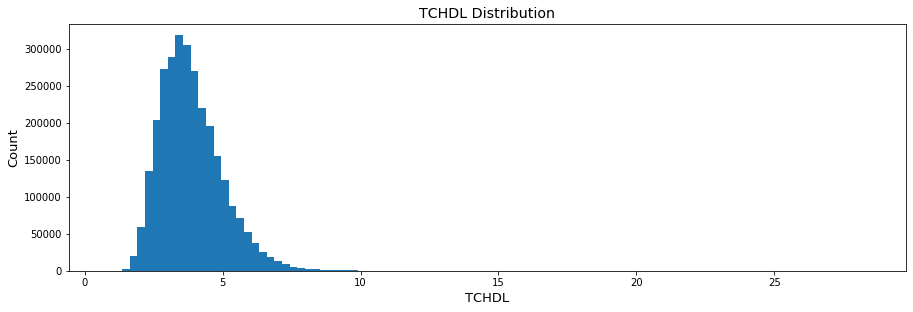

Max: 28.4
Min: 0.8


In [5]:
pyplot.figure(figsize=(15,10))
pyplot.subplot(211)
fs = 13
pyplot.title('TCHDL Distribution', fontsize=fs*1.1)
pyplot.xlabel('TCHDL', fontsize=fs)
pyplot.ylabel('Count', fontsize=fs)
pyplot.hist(view_1hot_df.TCHDL, bins=100)
#filename = "/home/whsu014/plots/LDL_Distribution.png"
#pyplot.savefig(filename)
pyplot.show()

print("Max:", max(view_1hot_df.TCHDL))
print("Min:", min(view_1hot_df.TCHDL))

In [6]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set to length 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


In [7]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [8]:
print(scaled_train.shape)
print(view_1hot_df.columns.get_loc('TCHDL'))
print(list(view_1hot_df.columns))

(2520000, 182)
14
['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'TESTED', 'DIED', 'LL_SIMVASTATIN', 'LL_BEZAFIBRATE', 'LL_ATORVASTATIN', 'LL_EZETIMIBE', 'LL_NICOTINIC_ACID', 'LL_ACIPIMOX', 'LL_CHOLESTYRAMINE', 'LL_COLESTIPOL_HYDROCHLORIDE', 'LL_PRAVASTATIN', 'LL_EZETIMIBE_WITH_SIMVASTATIN', 'LL_GEMFIBROZIL', 'LL_PDC', 'CVD_FELODIPINE', 'CVD_QUINAPRIL', 'CVD_METOPROLOL_SUCCINATE', 'CVD_CILAZAPRIL', 'CVD_ATENOLOL', 'CVD_BENDROFLUMETHIAZIDE', 'CVD_WARFARIN_SODIUM', 'CVD_FUROSEMIDE', 'CVD_CELIPROLOL', 'CVD_DILTIAZEM_HYDROCHLORIDE', 'CVD_ASPIRIN', 'CVD_NIFEDIPINE', 'CVD_CAPTOPRIL', 'CVD_DIPYRIDAMOLE', 'CVD_CANDESARTAN_CILEXETIL', 'CVD_INDAPAMIDE', 'CVD_ENALAPRIL_MALEATE', 'CVD_SOTALOL', 'CVD_GLYCERYL_TRINITRATE', 'CVD_ISOSORBIDE_MONONITRATE', 'CVD_PINDOLOL', 'CVD_CARVEDILOL', 'CVD_METHYLDOPA', 'CVD_LOSARTAN_POTASSIUM', 'CVD_VERAPAMIL_HYDROCHLORIDE', 'CVD_AMILORIDE_HYDROCHLORIDE', 'CVD_CLONIDINE_

In [9]:
def set_up_xy(time_series):
    num_of_inds = time_series.shape[0]//28
    n_features = time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*7), 
                   dtype='float')
    _y = np.empty((num_of_inds, 20), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        ind_v = copy.deepcopy(time_series[(i*28):((i+1)*28), :])
        _x[i, :n_features] = copy.deepcopy(ind_v[0, :])
        for j in range(1, 8):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(ind_v[j, 1:])
        _y[i, :] = ind_v[8:28, 14]
    return _x, _y

In [10]:
print(scaled_train.shape)

x_train, y_train = set_up_xy(scaled_train)

#x_train, y_train = set_up_xy_aggregate(scaled_train)
#x_test, y_test = set_up_xy_aggregate(scaled_test)
print("x train", x_train.shape)
print("y train", y_train.shape)

(2520000, 182)
x train (90000, 1449)
y train (90000, 20)


In [11]:
def set_up_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    input_shape=(1449, ))) 
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(20, activation='linear')) #20
    model.compile(loss='mae', optimizer='adam')
    return model

In [12]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=50, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return min(history.history['val_loss'])

In [5]:
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [4, 8, 16, 32, 64] 
batch_size_list = [64, 128, 256, 512, 1024] 

start_time = time.time()

exp_record = []

for n_units in units_list:
    for b_size in batch_size_list:
        for f in range(5):#10
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_mlp = np.append(train2_y, train1_y, axis=0)

            start_time_inner = time.time()
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = set_up_model(n_units, 0.25, 0.25)
                v_loss = fit_model(model, train_x_mlp,
                                   train_y_mlp, b_size)
                
                print("#################################")
                print("Number of units:", n_units)
                print("Batch size:", b_size)
                print("Fold:", f)
                print("best val loss:", v_loss)
                exp_record.append([n_units, b_size, f, v_loss])
                print("#################################")
            if (f==4):
                print(exp_record)
            end_time = time.time()
            print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

Experiment record:
[[4, 64, 0, 0.5410411828358969], [4, 64, 1, 0.5002329071362813], [4, 64, 2, 0.4929028534889221], [4, 64, 3, 0.48338914579815334], [4, 64, 4, 0.49059349070654973], [4, 128, 0, 0.4688114935821957], [4, 128, 1, 0.5047322140799628], [4, 128, 2, 0.49793919033474393], [4, 128, 3, 0.5376920459535387], [4, 128, 4, 0.49146265999476113], [4, 256, 0, 0.4680532646709018], [4, 256, 1, 0.5005355128182305], [4, 256, 2, 0.5494366496404012], [4, 256, 3, 0.48163980269432066], [4, 256, 4, 0.5361153762075637], [4, 512, 0, 0.4922688070138295], [4, 512, 1, 0.4781151261064741], [4, 512, 2, 0.5123777656820085], [4, 512, 3, 0.48390340518951414], [4, 512, 4, 0.5040540413856507], [4, 1024, 0, 0.4875098838541243], [4, 1024, 1, 0.4843557064798143], [4, 1024, 2, 0.48902965694003636], [4, 1024, 3, 0.4856364157464769], [4, 1024, 4, 0.4797599421872033], [8, 64, 0, 0.4596067219310337], [8, 64, 1, 0.46685454734166465], [8, 64, 2, 0.47254488261540734], [8, 64, 3, 0.46472719727622136], [8, 64, 4, 0.4685

In [18]:
exp_record = [[4, 64, 0, 0.5410411828358969], [4, 64, 1, 0.5002329071362813], [4, 64, 2, 0.4929028534889221], [4, 64, 3, 0.48338914579815334], [4, 64, 4, 0.49059349070654973], [4, 128, 0, 0.4688114935821957], [4, 128, 1, 0.5047322140799628], [4, 128, 2, 0.49793919033474393], [4, 128, 3, 0.5376920459535387], [4, 128, 4, 0.49146265999476113], [4, 256, 0, 0.4680532646709018], [4, 256, 1, 0.5005355128182305], [4, 256, 2, 0.5494366496404012], [4, 256, 3, 0.48163980269432066], [4, 256, 4, 0.5361153762075637], [4, 512, 0, 0.4922688070138295], [4, 512, 1, 0.4781151261064741], [4, 512, 2, 0.5123777656820085], [4, 512, 3, 0.48390340518951414], [4, 512, 4, 0.5040540413856507], [4, 1024, 0, 0.4875098838541243], [4, 1024, 1, 0.4843557064798143], [4, 1024, 2, 0.48902965694003636], [4, 1024, 3, 0.4856364157464769], [4, 1024, 4, 0.4797599421872033], [8, 64, 0, 0.4596067219310337], [8, 64, 1, 0.46685454734166465], [8, 64, 2, 0.47254488261540734], [8, 64, 3, 0.46472719727622136], [8, 64, 4, 0.4685618521372477], [8, 128, 0, 0.4855186248885261], [8, 128, 1, 0.4653631771405538], [8, 128, 2, 0.4714204495747884], [8, 128, 3, 0.4647866853343116], [8, 128, 4, 0.47173236656188966], [8, 256, 0, 0.46512276135550606], [8, 256, 1, 0.45559274657567345], [8, 256, 2, 0.4773876852459378], [8, 256, 3, 0.46261315064960057], [8, 256, 4, 0.4742779539955987], [8, 512, 0, 0.4718043007850647], [8, 512, 1, 0.4605038625134362], [8, 512, 2, 0.4781053807735443], [8, 512, 3, 0.474678591410319], [8, 512, 4, 0.4651362692779965], [8, 1024, 0, 0.46434670103920833], [8, 1024, 1, 0.4676304503281911], [8, 1024, 2, 0.46868806857532924], [8, 1024, 3, 0.4548741059833103], [8, 1024, 4, 0.47922697067260744], [16, 64, 0, 0.4613522389729818], [16, 64, 1, 0.4630499875810411], [16, 64, 2, 0.4625250808927748], [16, 64, 3, 0.457672560400433], [16, 64, 4, 0.45664207956526015], [16, 128, 0, 0.45997184194458857], [16, 128, 1, 0.4635424682829115], [16, 128, 2, 0.46320453262329103], [16, 128, 3, 0.45479238748550416], [16, 128, 4, 0.4592704850832621], [16, 256, 0, 0.4525675658120049], [16, 256, 1, 0.45291207975811426], [16, 256, 2, 0.46430950842963326], [16, 256, 3, 0.45977443485789826], [16, 256, 4, 0.4575382228957282], [16, 512, 0, 0.4545019599596659], [16, 512, 1, 0.45766111967298717], [16, 512, 2, 0.46148564823468524], [16, 512, 3, 0.46029236862394546], [16, 512, 4, 0.4593775179915958], [16, 1024, 0, 0.4577911320262485], [16, 1024, 1, 0.4556042674647437], [16, 1024, 2, 0.4609060285621219], [16, 1024, 3, 0.45956003051333955], [16, 1024, 4, 0.45879438047938875], [32, 64, 0, 0.4551976198090447], [32, 64, 1, 0.45500991124576995], [32, 64, 2, 0.45040077063772416], [32, 64, 3, 0.455414819293552], [32, 64, 4, 0.4515298687087165], [32, 128, 0, 0.44909441794289484], [32, 128, 1, 0.4522117764684889], [32, 128, 2, 0.4550444761382209], [32, 128, 3, 0.44780572652816775], [32, 128, 4, 0.45147022872500947], [32, 256, 0, 0.4484909847577413], [32, 256, 1, 0.44975339510705736], [32, 256, 2, 0.4562610594431559], [32, 256, 3, 0.44723543524742126], [32, 256, 4, 0.4517313676410251], [32, 512, 0, 0.45073932947052847], [32, 512, 1, 0.4483433613512251], [32, 512, 2, 0.4537335951063368], [32, 512, 3, 0.44887643933296206], [32, 512, 4, 0.4526524505350325], [32, 1024, 0, 0.45125779922803244], [32, 1024, 1, 0.4480725608401828], [32, 1024, 2, 0.4581719372007582], [32, 1024, 3, 0.4526053981516096], [32, 1024, 4, 0.45210657485326133], [64, 64, 0, 0.4477520059479608], [64, 64, 1, 0.4489692290094164], [64, 64, 2, 0.45009550905227663], [64, 64, 3, 0.44476118739446], [64, 64, 4, 0.447741333855523], [64, 128, 0, 0.44419322294659086], [64, 128, 1, 0.44544699226485357], [64, 128, 2, 0.4489245654741923], [64, 128, 3, 0.44469198327594334], [64, 128, 4, 0.4469932154549493], [64, 256, 0, 0.4453430537647671], [64, 256, 1, 0.4493532518280877], [64, 256, 2, 0.44674719757503933], [64, 256, 3, 0.44348919404877557], [64, 256, 4, 0.4454045390552945], [64, 512, 0, 0.4455738762219747], [64, 512, 1, 0.4457982313632965], [64, 512, 2, 0.44847502040863035], [64, 512, 3, 0.4417842783133189], [64, 512, 4, 0.446406283431583], [64, 1024, 0, 0.4463700031969282], [64, 1024, 1, 0.4438208175235324], [64, 1024, 2, 0.4500714856783549], [64, 1024, 3, 0.44253510755962794], [64, 1024, 4, 0.4467485424677531], [128, 64, 0, 0.449318035364151], [128, 64, 1, 0.4461579967074924], [128, 64, 2, 0.44986907807985943], [128, 64, 3, 0.44623757359716626], [128, 64, 4, 0.44733820819854736], [128, 128, 0, 0.443741844813029], [128, 128, 1, 0.44390553447935316], [128, 128, 2, 0.44847315430641177], [128, 128, 3, 0.4418690130975511], [128, 128, 4, 0.445863917350769], [128, 256, 0, 0.4431691504319509], [128, 256, 1, 0.4438138079908159], [128, 256, 2, 0.44722515426741705], [128, 256, 3, 0.44051554192437065], [128, 256, 4, 0.4451243857277764], [128, 512, 0, 0.44433030438423154], [128, 512, 1, 0.4432887134552002], [128, 512, 2, 0.4473800236119164], [128, 512, 3, 0.4406267348660363], [128, 512, 4, 0.44621526924769084], [128, 1024, 0, 0.4455215137269762], [128, 1024, 1, 0.44307362145847745], [128, 1024, 2, 0.44884115473429365], [128, 1024, 3, 0.44292919998698765], [128, 1024, 4, 0.4449291516674889], [256, 64, 0, 0.45181200403637356], [256, 64, 1, 0.4466715520752801], [256, 64, 2, 0.45150376704004075], [256, 64, 3, 0.4477441865603129], [256, 64, 4, 0.44880792723761664], [256, 128, 0, 0.44480430629518297], [256, 128, 1, 0.44380282786157393], [256, 128, 2, 0.4494152621693081], [256, 128, 3, 0.44417220057381523], [256, 128, 4, 0.44786996279822455], [256, 256, 0, 0.44292828644646537], [256, 256, 1, 0.4430221083164215], [256, 256, 2, 0.44709162730640833], [256, 256, 3, 0.4393189699649811], [256, 256, 4, 0.44677997663285995], [256, 512, 0, 0.44389220831129284], [256, 512, 1, 0.44397590086195204], [256, 512, 2, 0.4470799276034037], [256, 512, 3, 0.4396925338904063], [256, 512, 4, 0.4454240353372362], [256, 1024, 0, 0.4448934019141727], [256, 1024, 1, 0.44241160435146754], [256, 1024, 2, 0.44803489838706123], [256, 1024, 3, 0.4412776651117537], [256, 1024, 4, 0.44507162170939973], [512, 64, 0, 0.4565171818733215], [512, 64, 1, 0.4495252454545763], [512, 64, 2, 0.45511050817701554], [512, 64, 3, 0.4470248458120558], [512, 64, 4, 0.4497043594784207], [512, 128, 0, 0.44772533745235865], [512, 128, 1, 0.4478206698629591], [512, 128, 2, 0.4514574054876963], [512, 128, 3, 0.4473815400865343], [512, 128, 4, 0.4492212551964654], [512, 256, 0, 0.4441471055878533], [512, 256, 1, 0.4461581420368618], [512, 256, 2, 0.4497332316504584], [512, 256, 3, 0.4417938021024068], [512, 256, 4, 0.44661076958974205], [512, 512, 0, 0.4435602819919586], [512, 512, 1, 0.4450397034486135], [512, 512, 2, 0.44673092881838483], [512, 512, 3, 0.4418796185122596], [512, 512, 4, 0.44748834946420457], [512, 1024, 0, 0.44473128639327153], [512, 1024, 1, 0.44416347654660543], [512, 1024, 2, 0.4489981824821896], [512, 1024, 3, 0.44237750821643407], [512, 1024, 4, 0.4464644492732154]]

record_v = np.array(exp_record)

print(record_v.shape)

mean_list = []
step_size = 5
for i in range(40): 
    h_record = record_v[(i*step_size):((i+1)*step_size), :]
    print("##########################")
    print("Units: \t\t", h_record[0, 0])
    print("Batch_size: \t", h_record[0, 1])
    #print("Val loss (mean):", np.mean(h_record[:, 3]))
    #print("Val loss (std):\t", np.std(h_record[:, 3]))
    print("Val loss (mean):", np.round(np.mean(h_record[:, 3]), decimals=5))
    print("Val loss (std): ", np.round(np.std(h_record[:, 3]), decimals=5))
    print("##########################")
    mean_list.append(np.mean(h_record[:, 3]))
print(len(mean_list))
print(min(mean_list))

(200, 4)
##########################
Units: 		 4.0
Batch_size: 	 64.0
Val loss (mean): 0.50163
Val loss (std):  0.02042
##########################
##########################
Units: 		 4.0
Batch_size: 	 128.0
Val loss (mean): 0.50013
Val loss (std):  0.02233
##########################
##########################
Units: 		 4.0
Batch_size: 	 256.0
Val loss (mean): 0.50716
Val loss (std):  0.03115
##########################
##########################
Units: 		 4.0
Batch_size: 	 512.0
Val loss (mean): 0.49414
Val loss (std):  0.01262
##########################
##########################
Units: 		 4.0
Batch_size: 	 1024.0
Val loss (mean): 0.48526
Val loss (std):  0.00318
##########################
##########################
Units: 		 8.0
Batch_size: 	 64.0
Val loss (mean): 0.46646
Val loss (std):  0.00428
##########################
##########################
Units: 		 8.0
Batch_size: 	 128.0
Val loss (mean): 0.47176
Val loss (std):  0.00747
##########################
##########################

In [4]:
n_units = 256
model = Sequential()
model.add(Dense(n_units, activation='relu', 
                    input_shape=(1449, ))) #1457
model.add(Dropout(0.25))
model.add(Dense(n_units, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(20, activation='linear')) #20
model.compile(loss='mae', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               371200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                5140      
Total params: 442,132
Trainable params: 442,132
Non-trainable params: 0
_______________

In [17]:
###########################
# generate random numbers
# for dropout rate
###########################
from numpy.random import seed
seed(5) #0.0 - 0.5 seed(1) 0.5 - 1.0 seed(5)
# dropout rate for 1st dropout
# layer (between 0.0 and 0.5)
dropout_rate_1_list = []
for i in range(25):
    dropout_rate_1_list.append(np.random.uniform(0.5, 1.0))
# dropout rate for 2nd dropout
# layer (between 0.0 and 0.5)
dropout_rate_2_list = []
for i in range(25):
    dropout_rate_2_list.append(np.random.uniform(0.0, 0.5))
print(min(dropout_rate_1_list))
print(max(dropout_rate_1_list))
print(min(dropout_rate_2_list))
print(max(dropout_rate_2_list))
print(dropout_rate_1_list)
print(dropout_rate_2_list)

0.5403706343824375
0.9593054539689607
0.000821086358022638
0.4928122014020944
[0.6109965855448698, 0.9353661530886882, 0.6033595776697132, 0.9593054539689607, 0.7442055943974146, 0.8058719314513229, 0.8829539282401577, 0.7592089939364717, 0.648400250788111, 0.5938606143306258, 0.5403706343824375, 0.869220148099485, 0.7206546114479766, 0.5791549338563255, 0.9399685156006394, 0.6370432309961123, 0.7071175095405257, 0.6480399663668239, 0.8143939544397416, 0.7899189050947726, 0.7999645983124938, 0.6329095587677536, 0.642342940320682, 0.6267941028868937, 0.6637819738443671]
[0.07208215032671023, 0.0828064306006338, 0.4819652645339709, 0.4801133576428469, 0.09420732779796759, 0.012153280814743483, 0.10227777318997533, 0.34992180706327874, 0.3897572927777649, 0.01146654621954074, 0.288831429064878, 0.000821086358022638, 0.25773630595269675, 0.31989758806542856, 0.4928122014020944, 0.12954879820555287, 0.4012484426314351, 0.43524154350074157, 0.46137480697283495, 0.0011071062662217912, 0.23474

In [26]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

start_time = time.time()

n_units = 256
b_size = 256

exp_record = []

for i in range(25):
    dropout_rate_1 = dropout_rate_1_list[i]
    dropout_rate_2 = dropout_rate_2_list[i]
    for f in range(5):
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_mlp = np.append(train2_y, train1_y, axis=0)

        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = set_up_model(n_units, 
                                 dropout_rate_1, 
                                 dropout_rate_2)
            v_loss = fit_model(model, train_x_mlp, 
                               train_y_mlp, b_size)
            print("#################################")
            print("Number of units:", n_units)
            print("Batch size:", b_size)
            print("Dropout rate 1:", dropout_rate_1)
            print("Dropout rate 2:", dropout_rate_2)
            print("Fold:", f)
            print("Best val loss:", v_loss)
            exp_record.append([n_units, b_size, 
                               dropout_rate_1, 
                               dropout_rate_2, 
                               f, v_loss])
            print("#################################")
            if(f==4):
                print(exp_record)
        print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

Experiment record:
[[256, 256, 0.6109965855448698, 0.07208215032671023, 0, 0.45285117824872334], [256, 256, 0.6109965855448698, 0.07208215032671023, 1, 0.4554054328600566], [256, 256, 0.6109965855448698, 0.07208215032671023, 2, 0.44866279564963446], [256, 256, 0.6109965855448698, 0.07208215032671023, 3, 0.45003449275758534], [256, 256, 0.6109965855448698, 0.07208215032671023, 4, 0.4462551639874776], [256, 256, 0.9353661530886882, 0.0828064306006338, 0, 0.5923920929961735], [256, 256, 0.9353661530886882, 0.0828064306006338, 1, 0.5950529455608792], [256, 256, 0.9353661530886882, 0.0828064306006338, 2, 0.5869843494097392], [256, 256, 0.9353661530886882, 0.0828064306006338, 3, 0.5885131789843241], [256, 256, 0.9353661530886882, 0.0828064306006338, 4, 0.5675628916422526], [256, 256, 0.6033595776697132, 0.4819652645339709, 0, 0.45337720833884343], [256, 256, 0.6033595776697132, 0.4819652645339709, 1, 0.44975913921991983], [256, 256, 0.6033595776697132, 0.4819652645339709, 2, 0.45180197069380

In [19]:
# L2 1 (0.0 - 0.5) L2 2 (0.0 - 0.5) exp_record = [[256, 256, 0.208511002351287, 0.44730333175192366, 0, 0.4449413256910112], [256, 256, 0.208511002351287, 0.44730333175192366, 1, 0.4457042021751404], [256, 256, 0.208511002351287, 0.44730333175192366, 2, 0.4497003807226817], [256, 256, 0.208511002351287, 0.44730333175192366, 3, 0.4410535437266032], [256, 256, 0.208511002351287, 0.44730333175192366, 4, 0.44680957550472683], [256, 256, 0.36016224672107905, 0.042522105684888956, 0, 0.44093020666970145], [256, 256, 0.36016224672107905, 0.042522105684888956, 1, 0.4412776165538364], [256, 256, 0.36016224672107905, 0.042522105684888956, 2, 0.4449919000996484], [256, 256, 0.36016224672107905, 0.042522105684888956, 3, 0.4379829826090071], [256, 256, 0.36016224672107905, 0.042522105684888956, 4, 0.44304243596394854], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 0, 0.44720172895325555], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 1, 0.44571351332134673], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 2, 0.450615671131346], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 3, 0.4436221491760678], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 4, 0.45099786297480265], [256, 256, 0.15116628631591988, 0.08491520978228445, 0, 0.4438536839220259], [256, 256, 0.15116628631591988, 0.08491520978228445, 1, 0.4441836787594689], [256, 256, 0.15116628631591988, 0.08491520978228445, 2, 0.4483697789510091], [256, 256, 0.15116628631591988, 0.08491520978228445, 3, 0.4405975553459591], [256, 256, 0.15116628631591988, 0.08491520978228445, 4, 0.44725784540176394], [256, 256, 0.07337794540855652, 0.43907125171470657, 0, 0.44589724418852067], [256, 256, 0.07337794540855652, 0.43907125171470657, 1, 0.44845832867092555], [256, 256, 0.07337794540855652, 0.43907125171470657, 2, 0.45075898530748154], [256, 256, 0.07337794540855652, 0.43907125171470657, 3, 0.44092950042088824], [256, 256, 0.07337794540855652, 0.43907125171470657, 4, 0.4487874586847093], [256, 256, 0.0461692973843989, 0.04917341691652505, 0, 0.44590281833542716], [256, 256, 0.0461692973843989, 0.04917341691652505, 1, 0.4468723423745897], [256, 256, 0.0461692973843989, 0.04917341691652505, 2, 0.4501225193871392], [256, 256, 0.0461692973843989, 0.04917341691652505, 3, 0.44154176537195844], [256, 256, 0.0461692973843989, 0.04917341691652505, 4, 0.4492267654207018], [256, 256, 0.09313010568883545, 0.21055381250252608, 0, 0.4450189253754086], [256, 256, 0.09313010568883545, 0.21055381250252608, 1, 0.44706158592965867], [256, 256, 0.09313010568883545, 0.21055381250252608, 2, 0.4489565489557054], [256, 256, 0.09313010568883545, 0.21055381250252608, 3, 0.442350809123781], [256, 256, 0.09313010568883545, 0.21055381250252608, 4, 0.4485151721106635], [256, 256, 0.17278036352152387, 0.47894476507525097, 0, 0.444452871799469], [256, 256, 0.17278036352152387, 0.47894476507525097, 1, 0.446513956255383], [256, 256, 0.17278036352152387, 0.47894476507525097, 2, 0.4498043049176534], [256, 256, 0.17278036352152387, 0.47894476507525097, 3, 0.4419342743025886], [256, 256, 0.17278036352152387, 0.47894476507525097, 4, 0.44818414682812163], [256, 256, 0.19838373711533497, 0.26658264248650854, 0, 0.44376487064361575], [256, 256, 0.19838373711533497, 0.26658264248650854, 1, 0.4456052605840895], [256, 256, 0.19838373711533497, 0.26658264248650854, 2, 0.4484255229102241], [256, 256, 0.19838373711533497, 0.26658264248650854, 3, 0.4409668314721849], [256, 256, 0.19838373711533497, 0.26658264248650854, 4, 0.4464802426762051], [256, 256, 0.2694083670016785, 0.3459385569752367, 0, 0.4435728431807624], [256, 256, 0.2694083670016785, 0.3459385569752367, 1, 0.44440972503026327], [256, 256, 0.2694083670016785, 0.3459385569752367, 2, 0.4481996036370595], [256, 256, 0.2694083670016785, 0.3459385569752367, 3, 0.4407368180486891], [256, 256, 0.2694083670016785, 0.3459385569752367, 4, 0.44651263978746203], [256, 256, 0.2095972572016474, 0.15775781550303147, 0, 0.4430621035363939], [256, 256, 0.2095972572016474, 0.15775781550303147, 1, 0.44308959515889484], [256, 256, 0.2095972572016474, 0.15775781550303147, 2, 0.4480949923197428], [256, 256, 0.2095972572016474, 0.15775781550303147, 3, 0.43886365217632717], [256, 256, 0.2095972572016474, 0.15775781550303147, 4, 0.4455765801535712], [256, 256, 0.34260975019837975, 0.34325046384079183, 0, 0.44248724712265863], [256, 256, 0.34260975019837975, 0.34325046384079183, 1, 0.44582478880882265], [256, 256, 0.34260975019837975, 0.34325046384079183, 2, 0.4485427688492669], [256, 256, 0.34260975019837975, 0.34325046384079183, 3, 0.44041033834881255], [256, 256, 0.34260975019837975, 0.34325046384079183, 4, 0.44559748872121174], [256, 256, 0.10222612486575872, 0.41731283594868646, 0, 0.44628689368565877], [256, 256, 0.10222612486575872, 0.41731283594868646, 1, 0.44814176604482864], [256, 256, 0.10222612486575872, 0.41731283594868646, 2, 0.4503333734406365], [256, 256, 0.10222612486575872, 0.41731283594868646, 3, 0.44234721650017633], [256, 256, 0.10222612486575872, 0.41731283594868646, 4, 0.4482390959527757], [256, 256, 0.4390587181954727, 0.009144138672095903, 0, 0.43878817603323195], [256, 256, 0.4390587181954727, 0.009144138672095903, 1, 0.44135061860084535], [256, 256, 0.4390587181954727, 0.009144138672095903, 2, 0.44455254411697387], [256, 256, 0.4390587181954727, 0.009144138672095903, 3, 0.43760893119706046], [256, 256, 0.4390587181954727, 0.009144138672095903, 4, 0.4419834627045525], [256, 256, 0.013693796598963082, 0.37507215747248374, 0, 0.4454054408603244], [256, 256, 0.013693796598963082, 0.37507215747248374, 1, 0.44776300173335604], [256, 256, 0.013693796598963082, 0.37507215747248374, 2, 0.45164936068322925], [256, 256, 0.013693796598963082, 0.37507215747248374, 3, 0.443443319161733], [256, 256, 0.013693796598963082, 0.37507215747248374, 4, 0.4476290701760186], [256, 256, 0.3352337550892011, 0.49443054445324736, 0, 0.4433734766377343], [256, 256, 0.3352337550892011, 0.49443054445324736, 1, 0.44613265864054363], [256, 256, 0.3352337550892011, 0.49443054445324736, 2, 0.4496835190984938], [256, 256, 0.3352337550892011, 0.49443054445324736, 3, 0.44106070730421276], [256, 256, 0.3352337550892011, 0.49443054445324736, 4, 0.446937244521247], [256, 256, 0.20865240118356349, 0.3740828271899197, 0, 0.4444500656657749], [256, 256, 0.20865240118356349, 0.3740828271899197, 1, 0.4434022665818532], [256, 256, 0.20865240118356349, 0.3740828271899197, 2, 0.44981584045622086], [256, 256, 0.20865240118356349, 0.3740828271899197, 3, 0.4411615913973914], [256, 256, 0.20865240118356349, 0.3740828271899197, 4, 0.44584240733252634], [256, 256, 0.27934491422287583, 0.1402219960322026, 0, 0.44206492439905803], [256, 256, 0.27934491422287583, 0.1402219960322026, 1, 0.4442340757317013], [256, 256, 0.27934491422287583, 0.1402219960322026, 2, 0.44801246473524303], [256, 256, 0.27934491422287583, 0.1402219960322026, 3, 0.43908103391859266], [256, 256, 0.27934491422287583, 0.1402219960322026, 4, 0.44464678790834217], [256, 256, 0.07019346929761688, 0.39463966422574426, 0, 0.44514034191767377], [256, 256, 0.07019346929761688, 0.39463966422574426, 1, 0.44732348420884877], [256, 256, 0.07019346929761688, 0.39463966422574426, 2, 0.45080826693111], [256, 256, 0.07019346929761688, 0.39463966422574426, 3, 0.44252059327231513], [256, 256, 0.07019346929761688, 0.39463966422574426, 4, 0.44875715610716077], [256, 256, 0.0990507445424394, 0.05161300328882101, 0, 0.44611068953408134], [256, 256, 0.0990507445424394, 0.05161300328882101, 1, 0.44570699410968356], [256, 256, 0.0990507445424394, 0.05161300328882101, 2, 0.44882443324724836], [256, 256, 0.0990507445424394, 0.05161300328882101, 3, 0.4410980356004503], [256, 256, 0.0990507445424394, 0.05161300328882101, 4, 0.44600790283415054], [256, 256, 0.40037228433776834, 0.22394676308795258, 0, 0.4423760610951318], [256, 256, 0.40037228433776834, 0.22394676308795258, 1, 0.4441993712849087], [256, 256, 0.40037228433776834, 0.22394676308795258, 2, 0.4465054792298211], [256, 256, 0.40037228433776834, 0.22394676308795258, 3, 0.4392771972815196], [256, 256, 0.40037228433776834, 0.22394676308795258, 4, 0.4453276397917006], [256, 256, 0.48413078785969876, 0.4542977515465478, 0, 0.44433036936653986], [256, 256, 0.48413078785969876, 0.4542977515465478, 1, 0.4454060884846581], [256, 256, 0.48413078785969876, 0.4542977515465478, 2, 0.4477737490071191], [256, 256, 0.48413078785969876, 0.4542977515465478, 3, 0.4422704819308387], [256, 256, 0.48413078785969876, 0.4542977515465478, 4, 0.44606853771209715], [256, 256, 0.15671208907962142, 0.14680707418683975, 0, 0.4442231266763475], [256, 256, 0.15671208907962142, 0.14680707418683975, 1, 0.4446613549126519], [256, 256, 0.15671208907962142, 0.14680707418683975, 2, 0.4491972921689351], [256, 256, 0.15671208907962142, 0.14680707418683975, 3, 0.43971731209754944], [256, 256, 0.15671208907962142, 0.14680707418683975, 4, 0.44598339981502955], [256, 256, 0.34616130783465704, 0.14388766929317437, 0, 0.4421806991100311], [256, 256, 0.34616130783465704, 0.14388766929317437, 1, 0.44392105862829423], [256, 256, 0.34616130783465704, 0.14388766929317437, 2, 0.4478100979593065], [256, 256, 0.34616130783465704, 0.14388766929317437, 3, 0.43840112617280746], [256, 256, 0.34616130783465704, 0.14388766929317437, 4, 0.44471299770143297], [256, 256, 0.43819457614801915, 0.06501428605913884, 0, 0.4426546173095703], [256, 256, 0.43819457614801915, 0.06501428605913884, 1, 0.44267802744441564], [256, 256, 0.43819457614801915, 0.06501428605913884, 2, 0.44473025782903036], [256, 256, 0.43819457614801915, 0.06501428605913884, 3, 0.439012702120675], [256, 256, 0.43819457614801915, 0.06501428605913884, 4, 0.44288310877482095]]
# L2 1 (0.5 - 1.0) L2 2 (0.0 - 0.5) exp_record = [[256, 256, 0.6109965855448698, 0.07208215032671023, 0, 0.45285117824872334], [256, 256, 0.6109965855448698, 0.07208215032671023, 1, 0.4554054328600566], [256, 256, 0.6109965855448698, 0.07208215032671023, 2, 0.44866279564963446], [256, 256, 0.6109965855448698, 0.07208215032671023, 3, 0.45003449275758534], [256, 256, 0.6109965855448698, 0.07208215032671023, 4, 0.4462551639874776], [256, 256, 0.9353661530886882, 0.0828064306006338, 0, 0.5923920929961735], [256, 256, 0.9353661530886882, 0.0828064306006338, 1, 0.5950529455608792], [256, 256, 0.9353661530886882, 0.0828064306006338, 2, 0.5869843494097392], [256, 256, 0.9353661530886882, 0.0828064306006338, 3, 0.5885131789843241], [256, 256, 0.9353661530886882, 0.0828064306006338, 4, 0.5675628916422526], [256, 256, 0.6033595776697132, 0.4819652645339709, 0, 0.45337720833884343], [256, 256, 0.6033595776697132, 0.4819652645339709, 1, 0.44975913921991983], [256, 256, 0.6033595776697132, 0.4819652645339709, 2, 0.4518019706938002], [256, 256, 0.6033595776697132, 0.4819652645339709, 3, 0.44465552854537965], [256, 256, 0.6033595776697132, 0.4819652645339709, 4, 0.44909383858574764], [256, 256, 0.9593054539689607, 0.4801133576428469, 0, 0.6552621070014106], [256, 256, 0.9593054539689607, 0.4801133576428469, 1, 0.6494424088266161], [256, 256, 0.9593054539689607, 0.4801133576428469, 2, 0.6368807804319594], [256, 256, 0.9593054539689607, 0.4801133576428469, 3, 0.6414348734219869], [256, 256, 0.9593054539689607, 0.4801133576428469, 4, 0.6504319033622742], [256, 256, 0.7442055943974146, 0.09420732779796759, 0, 0.4855458244217767], [256, 256, 0.7442055943974146, 0.09420732779796759, 1, 0.4891367478900486], [256, 256, 0.7442055943974146, 0.09420732779796759, 2, 0.48787063349617854], [256, 256, 0.7442055943974146, 0.09420732779796759, 3, 0.4946734602716234], [256, 256, 0.7442055943974146, 0.09420732779796759, 4, 0.49407930496003893], [256, 256, 0.8058719314513229, 0.012153280814743483, 0, 0.4910553152826097], [256, 256, 0.8058719314513229, 0.012153280814743483, 1, 0.5033110591040717], [256, 256, 0.8058719314513229, 0.012153280814743483, 2, 0.5096990093655056], [256, 256, 0.8058719314513229, 0.012153280814743483, 3, 0.5065453134642707], [256, 256, 0.8058719314513229, 0.012153280814743483, 4, 0.4947051918241713], [256, 256, 0.8829539282401577, 0.10227777318997533, 0, 0.600078285853068], [256, 256, 0.8829539282401577, 0.10227777318997533, 1, 0.5970399554040697], [256, 256, 0.8829539282401577, 0.10227777318997533, 2, 0.5964320777257284], [256, 256, 0.8829539282401577, 0.10227777318997533, 3, 0.6031138050291274], [256, 256, 0.8829539282401577, 0.10227777318997533, 4, 0.5773900507820977], [256, 256, 0.7592089939364717, 0.34992180706327874, 0, 0.5034791997803582], [256, 256, 0.7592089939364717, 0.34992180706327874, 1, 0.5088311755922106], [256, 256, 0.7592089939364717, 0.34992180706327874, 2, 0.5038059455553691], [256, 256, 0.7592089939364717, 0.34992180706327874, 3, 0.5008016268412272], [256, 256, 0.7592089939364717, 0.34992180706327874, 4, 0.4872706200281779], [256, 256, 0.648400250788111, 0.3897572927777649, 0, 0.45545830467012194], [256, 256, 0.648400250788111, 0.3897572927777649, 1, 0.4585841649638282], [256, 256, 0.648400250788111, 0.3897572927777649, 2, 0.4569815029303233], [256, 256, 0.648400250788111, 0.3897572927777649, 3, 0.45725073432922364], [256, 256, 0.648400250788111, 0.3897572927777649, 4, 0.4550965240266588], [256, 256, 0.5938606143306258, 0.01146654621954074, 0, 0.4418101094033983], [256, 256, 0.5938606143306258, 0.01146654621954074, 1, 0.44321298262808057], [256, 256, 0.5938606143306258, 0.01146654621954074, 2, 0.4454001203642951], [256, 256, 0.5938606143306258, 0.01146654621954074, 3, 0.44122039371066624], [256, 256, 0.5938606143306258, 0.01146654621954074, 4, 0.44373677608701917], [256, 256, 0.5403706343824375, 0.288831429064878, 0, 0.4459821355342865], [256, 256, 0.5403706343824375, 0.288831429064878, 1, 0.4475766589376661], [256, 256, 0.5403706343824375, 0.288831429064878, 2, 0.44733439954121906], [256, 256, 0.5403706343824375, 0.288831429064878, 3, 0.4445236116780175], [256, 256, 0.5403706343824375, 0.288831429064878, 4, 0.44584053341547647], [256, 256, 0.869220148099485, 0.000821086358022638, 0, 0.5026328567398919], [256, 256, 0.869220148099485, 0.000821086358022638, 1, 0.5021655045615302], [256, 256, 0.869220148099485, 0.000821086358022638, 2, 0.4972846522861057], [256, 256, 0.869220148099485, 0.000821086358022638, 3, 0.4853536393907335], [256, 256, 0.869220148099485, 0.000821086358022638, 4, 0.4919908677207099], [256, 256, 0.7206546114479766, 0.25773630595269675, 0, 0.48527182369761995], [256, 256, 0.7206546114479766, 0.25773630595269675, 1, 0.4801100592083401], [256, 256, 0.7206546114479766, 0.25773630595269675, 2, 0.4890927741792467], [256, 256, 0.7206546114479766, 0.25773630595269675, 3, 0.47909910440444947], [256, 256, 0.7206546114479766, 0.25773630595269675, 4, 0.47249018727408515], [256, 256, 0.5791549338563255, 0.31989758806542856, 0, 0.4486257993380229], [256, 256, 0.5791549338563255, 0.31989758806542856, 1, 0.45029162549972535], [256, 256, 0.5791549338563255, 0.31989758806542856, 2, 0.44899869389004177], [256, 256, 0.5791549338563255, 0.31989758806542856, 3, 0.4514780361917284], [256, 256, 0.5791549338563255, 0.31989758806542856, 4, 0.4473867326312595], [256, 256, 0.9399685156006394, 0.4928122014020944, 0, 0.6500129381815593], [256, 256, 0.9399685156006394, 0.4928122014020944, 1, 0.6459125770992703], [256, 256, 0.9399685156006394, 0.4928122014020944, 2, 0.6513543783823649], [256, 256, 0.9399685156006394, 0.4928122014020944, 3, 0.6366362615161472], [256, 256, 0.9399685156006394, 0.4928122014020944, 4, 0.6367273104985555], [256, 256, 0.6370432309961123, 0.12954879820555287, 0, 0.4532493451436361], [256, 256, 0.6370432309961123, 0.12954879820555287, 1, 0.4527297083536784], [256, 256, 0.6370432309961123, 0.12954879820555287, 2, 0.4610188421143426], [256, 256, 0.6370432309961123, 0.12954879820555287, 3, 0.45827791346444025], [256, 256, 0.6370432309961123, 0.12954879820555287, 4, 0.45182418415281506], [256, 256, 0.7071175095405257, 0.4012484426314351, 0, 0.4773127812544505], [256, 256, 0.7071175095405257, 0.4012484426314351, 1, 0.47589888752831355], [256, 256, 0.7071175095405257, 0.4012484426314351, 2, 0.4773688685629103], [256, 256, 0.7071175095405257, 0.4012484426314351, 3, 0.46888421482510034], [256, 256, 0.7071175095405257, 0.4012484426314351, 4, 0.46075317488776313], [256, 256, 0.6480399663668239, 0.43524154350074157, 0, 0.4542016192277272], [256, 256, 0.6480399663668239, 0.43524154350074157, 1, 0.45576709116829767], [256, 256, 0.6480399663668239, 0.43524154350074157, 2, 0.4573961799939473], [256, 256, 0.6480399663668239, 0.43524154350074157, 3, 0.4480839222802056], [256, 256, 0.6480399663668239, 0.43524154350074157, 4, 0.45204221216837565], [256, 256, 0.8143939544397416, 0.46137480697283495, 0, 0.5401024485164219], [256, 256, 0.8143939544397416, 0.46137480697283495, 1, 0.5429765306578742], [256, 256, 0.8143939544397416, 0.46137480697283495, 2, 0.5346331676907009], [256, 256, 0.8143939544397416, 0.46137480697283495, 3, 0.5386706921259562], [256, 256, 0.8143939544397416, 0.46137480697283495, 4, 0.5253319462140401], [256, 256, 0.7899189050947726, 0.0011071062662217912, 0, 0.467589382092158], [256, 256, 0.7899189050947726, 0.0011071062662217912, 1, 0.47246831528345745], [256, 256, 0.7899189050947726, 0.0011071062662217912, 2, 0.48352294656965467], [256, 256, 0.7899189050947726, 0.0011071062662217912, 3, 0.46447562339570786], [256, 256, 0.7899189050947726, 0.0011071062662217912, 4, 0.4696592819425795], [256, 256, 0.7999645983124938, 0.23474418587878865, 0, 0.5226658760971493], [256, 256, 0.7999645983124938, 0.23474418587878865, 1, 0.5296502685017056], [256, 256, 0.7999645983124938, 0.23474418587878865, 2, 0.5257898635864258], [256, 256, 0.7999645983124938, 0.23474418587878865, 3, 0.5310232543945312], [256, 256, 0.7999645983124938, 0.23474418587878865, 4, 0.5216871584786309], [256, 256, 0.6329095587677536, 0.49073436880300525, 0, 0.45530818030569287], [256, 256, 0.6329095587677536, 0.49073436880300525, 1, 0.45521854151619806], [256, 256, 0.6329095587677536, 0.49073436880300525, 2, 0.4539175461133321], [256, 256, 0.6329095587677536, 0.49073436880300525, 3, 0.44423768875333997], [256, 256, 0.6329095587677536, 0.49073436880300525, 4, 0.4521788206630283], [256, 256, 0.642342940320682, 0.19947240195142524, 0, 0.45986993307537505], [256, 256, 0.642342940320682, 0.19947240195142524, 1, 0.46772257788976035], [256, 256, 0.642342940320682, 0.19947240195142524, 2, 0.45925723886489866], [256, 256, 0.642342940320682, 0.19947240195142524, 3, 0.45948378123177425], [256, 256, 0.642342940320682, 0.19947240195142524, 4, 0.45496570958031546], [256, 256, 0.6267941028868937, 0.40686623879345907, 0, 0.45125754510031807], [256, 256, 0.6267941028868937, 0.40686623879345907, 1, 0.45061182067129346], [256, 256, 0.6267941028868937, 0.40686623879345907, 2, 0.4545886885325114], [256, 256, 0.6267941028868937, 0.40686623879345907, 3, 0.45143867346975536], [256, 256, 0.6267941028868937, 0.40686623879345907, 4, 0.44762628157933554], [256, 256, 0.6637819738443671, 0.2732282489862389, 0, 0.45984525632858275], [256, 256, 0.6637819738443671, 0.2732282489862389, 1, 0.46974941953023275], [256, 256, 0.6637819738443671, 0.2732282489862389, 2, 0.46536880617671544], [256, 256, 0.6637819738443671, 0.2732282489862389, 3, 0.4628477338155111], [256, 256, 0.6637819738443671, 0.2732282489862389, 4, 0.45635017866558497]]
record_v = np.array(exp_record)
print(record_v.shape)

mean_list = []
for i in range(25):
    h_record = record_v[(i*5):((i+1)*5), :]
    print("##########################")
    print("Units: \t\t", h_record[0, 0])
    print("Batch_size: \t", h_record[0, 1])
    print("Dropout rate 1: ", h_record[0, 2])
    print("Dropout rate 2: ", h_record[0, 3])
    print("Val loss (mean):", np.round(np.mean(h_record[:, 5]), decimals=5))
    print("Val loss (std): ", np.round(np.std(h_record[:, 5]), decimals=5))
    print("##########################")
    mean_list.append(np.mean(h_record[:, 5]))
print(len(mean_list))
print(min(mean_list))

(125, 6)
##########################
Units: 		 256.0
Batch_size: 	 256.0
Dropout rate 1:  0.6109965855448698
Dropout rate 2:  0.07208215032671023
Val loss (mean): 0.45064
Val loss (std):  0.0032
##########################
##########################
Units: 		 256.0
Batch_size: 	 256.0
Dropout rate 1:  0.9353661530886882
Dropout rate 2:  0.0828064306006338
Val loss (mean): 0.5861
Val loss (std):  0.0097
##########################
##########################
Units: 		 256.0
Batch_size: 	 256.0
Dropout rate 1:  0.6033595776697132
Dropout rate 2:  0.4819652645339709
Val loss (mean): 0.44974
Val loss (std):  0.00296
##########################
##########################
Units: 		 256.0
Batch_size: 	 256.0
Dropout rate 1:  0.9593054539689607
Dropout rate 2:  0.4801133576428469
Val loss (mean): 0.64669
Val loss (std):  0.00662
##########################
##########################
Units: 		 256.0
Batch_size: 	 256.0
Dropout rate 1:  0.7442055943974146
Dropout rate 2:  0.09420732779796759
Val loss 

## Hyperparameters (units and batch_size) surface plot

In [19]:
x = np.array([4,8,16,32,64,128,256,512])
y = np.array([64,128,256,512,1024])
complete_list = [[0.50163,0.46646,0.46025,0.45351,0.44786,0.44778,0.44931,0.45158],
                 [0.50013,0.47176,0.46016,0.45113,0.44605,0.44477,0.44601,0.44872],
                 [0.50716,0.46700,0.45742,0.45069,0.44607,0.44397,0.44383,0.44569],
                 [0.49414,0.47005,0.45866,0.45087,0.44561,0.44437,0.44401,0.44494],
                 [0.48526,0.46695,0.45853,0.45244,0.44591,0.44506,0.44434,0.44535 ]]
X,Y = np.meshgrid(x, y)
print(X)
print(Y)
print(np.round(complete_list, decimals=5))

[[  4   8  16  32  64 128 256 512]
 [  4   8  16  32  64 128 256 512]
 [  4   8  16  32  64 128 256 512]
 [  4   8  16  32  64 128 256 512]
 [  4   8  16  32  64 128 256 512]]
[[  64   64   64   64   64   64   64   64]
 [ 128  128  128  128  128  128  128  128]
 [ 256  256  256  256  256  256  256  256]
 [ 512  512  512  512  512  512  512  512]
 [1024 1024 1024 1024 1024 1024 1024 1024]]
[[0.50163 0.46646 0.46025 0.45351 0.44786 0.44778 0.44931 0.45158]
 [0.50013 0.47176 0.46016 0.45113 0.44605 0.44477 0.44601 0.44872]
 [0.50716 0.467   0.45742 0.45069 0.44607 0.44397 0.44383 0.44569]
 [0.49414 0.47005 0.45866 0.45087 0.44561 0.44437 0.44401 0.44494]
 [0.48526 0.46695 0.45853 0.45244 0.44591 0.44506 0.44434 0.44535]]


(5, 8)
(5, 8)
(5, 8)


<IPython.core.display.Javascript object>


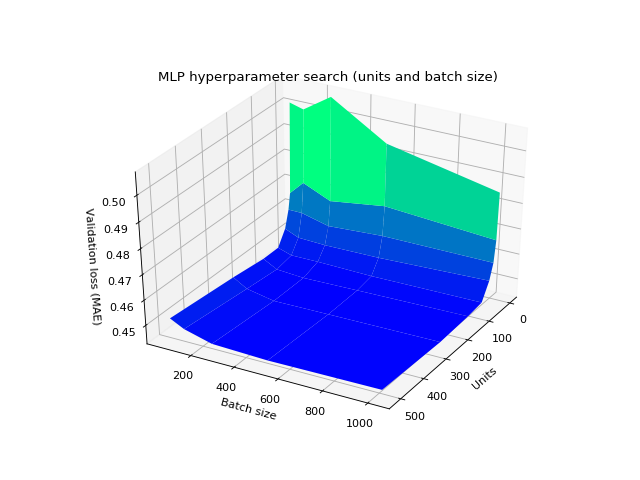

In [20]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits import mplot3d

x = np.array([4,8,16,32,64,128,256,512])
y = np.array([64,128,256,512,1024])
X,Y = np.meshgrid(x, y)
z = np.array(complete_list)
print(X.shape)
print(Y.shape)
print(z.shape)
fig = pyplot.figure(figsize=(8, 6))
ax = pyplot.axes(projection='3d')
#ax.plot_surface(X, Y, z,cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, z, color='g')
ax.set_xlabel('Units')
ax.set_ylabel('Batch size')
ax.set_zlabel('Validation loss (MAE)')
#ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title('MLP hyperparameter search (units and batch size)')
pyplot.show()

(125, 6)
(25, 3)


<IPython.core.display.Javascript object>


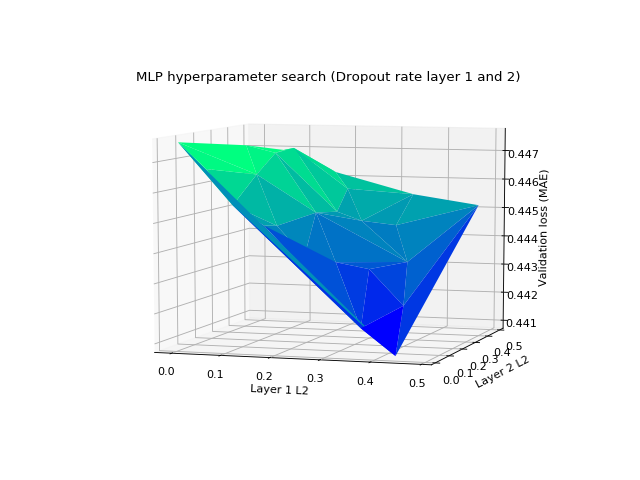

Text(0.5, 0.92, 'MLP hyperparameter search (Dropout rate layer 1 and 2)')

In [25]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D   
from mpl_toolkits import mplot3d

exp_record_I = [[256, 256, 0.208511002351287, 0.44730333175192366, 0, 0.4449413256910112], [256, 256, 0.208511002351287, 0.44730333175192366, 1, 0.4457042021751404], [256, 256, 0.208511002351287, 0.44730333175192366, 2, 0.4497003807226817], [256, 256, 0.208511002351287, 0.44730333175192366, 3, 0.4410535437266032], [256, 256, 0.208511002351287, 0.44730333175192366, 4, 0.44680957550472683], [256, 256, 0.36016224672107905, 0.042522105684888956, 0, 0.44093020666970145], [256, 256, 0.36016224672107905, 0.042522105684888956, 1, 0.4412776165538364], [256, 256, 0.36016224672107905, 0.042522105684888956, 2, 0.4449919000996484], [256, 256, 0.36016224672107905, 0.042522105684888956, 3, 0.4379829826090071], [256, 256, 0.36016224672107905, 0.042522105684888956, 4, 0.44304243596394854], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 0, 0.44720172895325555], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 1, 0.44571351332134673], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 2, 0.450615671131346], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 3, 0.4436221491760678], [256, 256, 5.718740867244332e-05, 0.01952739161644118, 4, 0.45099786297480265], [256, 256, 0.15116628631591988, 0.08491520978228445, 0, 0.4438536839220259], [256, 256, 0.15116628631591988, 0.08491520978228445, 1, 0.4441836787594689], [256, 256, 0.15116628631591988, 0.08491520978228445, 2, 0.4483697789510091], [256, 256, 0.15116628631591988, 0.08491520978228445, 3, 0.4405975553459591], [256, 256, 0.15116628631591988, 0.08491520978228445, 4, 0.44725784540176394], [256, 256, 0.07337794540855652, 0.43907125171470657, 0, 0.44589724418852067], [256, 256, 0.07337794540855652, 0.43907125171470657, 1, 0.44845832867092555], [256, 256, 0.07337794540855652, 0.43907125171470657, 2, 0.45075898530748154], [256, 256, 0.07337794540855652, 0.43907125171470657, 3, 0.44092950042088824], [256, 256, 0.07337794540855652, 0.43907125171470657, 4, 0.4487874586847093], [256, 256, 0.0461692973843989, 0.04917341691652505, 0, 0.44590281833542716], [256, 256, 0.0461692973843989, 0.04917341691652505, 1, 0.4468723423745897], [256, 256, 0.0461692973843989, 0.04917341691652505, 2, 0.4501225193871392], [256, 256, 0.0461692973843989, 0.04917341691652505, 3, 0.44154176537195844], [256, 256, 0.0461692973843989, 0.04917341691652505, 4, 0.4492267654207018], [256, 256, 0.09313010568883545, 0.21055381250252608, 0, 0.4450189253754086], [256, 256, 0.09313010568883545, 0.21055381250252608, 1, 0.44706158592965867], [256, 256, 0.09313010568883545, 0.21055381250252608, 2, 0.4489565489557054], [256, 256, 0.09313010568883545, 0.21055381250252608, 3, 0.442350809123781], [256, 256, 0.09313010568883545, 0.21055381250252608, 4, 0.4485151721106635], [256, 256, 0.17278036352152387, 0.47894476507525097, 0, 0.444452871799469], [256, 256, 0.17278036352152387, 0.47894476507525097, 1, 0.446513956255383], [256, 256, 0.17278036352152387, 0.47894476507525097, 2, 0.4498043049176534], [256, 256, 0.17278036352152387, 0.47894476507525097, 3, 0.4419342743025886], [256, 256, 0.17278036352152387, 0.47894476507525097, 4, 0.44818414682812163], [256, 256, 0.19838373711533497, 0.26658264248650854, 0, 0.44376487064361575], [256, 256, 0.19838373711533497, 0.26658264248650854, 1, 0.4456052605840895], [256, 256, 0.19838373711533497, 0.26658264248650854, 2, 0.4484255229102241], [256, 256, 0.19838373711533497, 0.26658264248650854, 3, 0.4409668314721849], [256, 256, 0.19838373711533497, 0.26658264248650854, 4, 0.4464802426762051], [256, 256, 0.2694083670016785, 0.3459385569752367, 0, 0.4435728431807624], [256, 256, 0.2694083670016785, 0.3459385569752367, 1, 0.44440972503026327], [256, 256, 0.2694083670016785, 0.3459385569752367, 2, 0.4481996036370595], [256, 256, 0.2694083670016785, 0.3459385569752367, 3, 0.4407368180486891], [256, 256, 0.2694083670016785, 0.3459385569752367, 4, 0.44651263978746203], [256, 256, 0.2095972572016474, 0.15775781550303147, 0, 0.4430621035363939], [256, 256, 0.2095972572016474, 0.15775781550303147, 1, 0.44308959515889484], [256, 256, 0.2095972572016474, 0.15775781550303147, 2, 0.4480949923197428], [256, 256, 0.2095972572016474, 0.15775781550303147, 3, 0.43886365217632717], [256, 256, 0.2095972572016474, 0.15775781550303147, 4, 0.4455765801535712], [256, 256, 0.34260975019837975, 0.34325046384079183, 0, 0.44248724712265863], [256, 256, 0.34260975019837975, 0.34325046384079183, 1, 0.44582478880882265], [256, 256, 0.34260975019837975, 0.34325046384079183, 2, 0.4485427688492669], [256, 256, 0.34260975019837975, 0.34325046384079183, 3, 0.44041033834881255], [256, 256, 0.34260975019837975, 0.34325046384079183, 4, 0.44559748872121174], [256, 256, 0.10222612486575872, 0.41731283594868646, 0, 0.44628689368565877], [256, 256, 0.10222612486575872, 0.41731283594868646, 1, 0.44814176604482864], [256, 256, 0.10222612486575872, 0.41731283594868646, 2, 0.4503333734406365], [256, 256, 0.10222612486575872, 0.41731283594868646, 3, 0.44234721650017633], [256, 256, 0.10222612486575872, 0.41731283594868646, 4, 0.4482390959527757], [256, 256, 0.4390587181954727, 0.009144138672095903, 0, 0.43878817603323195], [256, 256, 0.4390587181954727, 0.009144138672095903, 1, 0.44135061860084535], [256, 256, 0.4390587181954727, 0.009144138672095903, 2, 0.44455254411697387], [256, 256, 0.4390587181954727, 0.009144138672095903, 3, 0.43760893119706046], [256, 256, 0.4390587181954727, 0.009144138672095903, 4, 0.4419834627045525], [256, 256, 0.013693796598963082, 0.37507215747248374, 0, 0.4454054408603244], [256, 256, 0.013693796598963082, 0.37507215747248374, 1, 0.44776300173335604], [256, 256, 0.013693796598963082, 0.37507215747248374, 2, 0.45164936068322925], [256, 256, 0.013693796598963082, 0.37507215747248374, 3, 0.443443319161733], [256, 256, 0.013693796598963082, 0.37507215747248374, 4, 0.4476290701760186], [256, 256, 0.3352337550892011, 0.49443054445324736, 0, 0.4433734766377343], [256, 256, 0.3352337550892011, 0.49443054445324736, 1, 0.44613265864054363], [256, 256, 0.3352337550892011, 0.49443054445324736, 2, 0.4496835190984938], [256, 256, 0.3352337550892011, 0.49443054445324736, 3, 0.44106070730421276], [256, 256, 0.3352337550892011, 0.49443054445324736, 4, 0.446937244521247], [256, 256, 0.20865240118356349, 0.3740828271899197, 0, 0.4444500656657749], [256, 256, 0.20865240118356349, 0.3740828271899197, 1, 0.4434022665818532], [256, 256, 0.20865240118356349, 0.3740828271899197, 2, 0.44981584045622086], [256, 256, 0.20865240118356349, 0.3740828271899197, 3, 0.4411615913973914], [256, 256, 0.20865240118356349, 0.3740828271899197, 4, 0.44584240733252634], [256, 256, 0.27934491422287583, 0.1402219960322026, 0, 0.44206492439905803], [256, 256, 0.27934491422287583, 0.1402219960322026, 1, 0.4442340757317013], [256, 256, 0.27934491422287583, 0.1402219960322026, 2, 0.44801246473524303], [256, 256, 0.27934491422287583, 0.1402219960322026, 3, 0.43908103391859266], [256, 256, 0.27934491422287583, 0.1402219960322026, 4, 0.44464678790834217], [256, 256, 0.07019346929761688, 0.39463966422574426, 0, 0.44514034191767377], [256, 256, 0.07019346929761688, 0.39463966422574426, 1, 0.44732348420884877], [256, 256, 0.07019346929761688, 0.39463966422574426, 2, 0.45080826693111], [256, 256, 0.07019346929761688, 0.39463966422574426, 3, 0.44252059327231513], [256, 256, 0.07019346929761688, 0.39463966422574426, 4, 0.44875715610716077], [256, 256, 0.0990507445424394, 0.05161300328882101, 0, 0.44611068953408134], [256, 256, 0.0990507445424394, 0.05161300328882101, 1, 0.44570699410968356], [256, 256, 0.0990507445424394, 0.05161300328882101, 2, 0.44882443324724836], [256, 256, 0.0990507445424394, 0.05161300328882101, 3, 0.4410980356004503], [256, 256, 0.0990507445424394, 0.05161300328882101, 4, 0.44600790283415054], [256, 256, 0.40037228433776834, 0.22394676308795258, 0, 0.4423760610951318], [256, 256, 0.40037228433776834, 0.22394676308795258, 1, 0.4441993712849087], [256, 256, 0.40037228433776834, 0.22394676308795258, 2, 0.4465054792298211], [256, 256, 0.40037228433776834, 0.22394676308795258, 3, 0.4392771972815196], [256, 256, 0.40037228433776834, 0.22394676308795258, 4, 0.4453276397917006], [256, 256, 0.48413078785969876, 0.4542977515465478, 0, 0.44433036936653986], [256, 256, 0.48413078785969876, 0.4542977515465478, 1, 0.4454060884846581], [256, 256, 0.48413078785969876, 0.4542977515465478, 2, 0.4477737490071191], [256, 256, 0.48413078785969876, 0.4542977515465478, 3, 0.4422704819308387], [256, 256, 0.48413078785969876, 0.4542977515465478, 4, 0.44606853771209715], [256, 256, 0.15671208907962142, 0.14680707418683975, 0, 0.4442231266763475], [256, 256, 0.15671208907962142, 0.14680707418683975, 1, 0.4446613549126519], [256, 256, 0.15671208907962142, 0.14680707418683975, 2, 0.4491972921689351], [256, 256, 0.15671208907962142, 0.14680707418683975, 3, 0.43971731209754944], [256, 256, 0.15671208907962142, 0.14680707418683975, 4, 0.44598339981502955], [256, 256, 0.34616130783465704, 0.14388766929317437, 0, 0.4421806991100311], [256, 256, 0.34616130783465704, 0.14388766929317437, 1, 0.44392105862829423], [256, 256, 0.34616130783465704, 0.14388766929317437, 2, 0.4478100979593065], [256, 256, 0.34616130783465704, 0.14388766929317437, 3, 0.43840112617280746], [256, 256, 0.34616130783465704, 0.14388766929317437, 4, 0.44471299770143297], [256, 256, 0.43819457614801915, 0.06501428605913884, 0, 0.4426546173095703], [256, 256, 0.43819457614801915, 0.06501428605913884, 1, 0.44267802744441564], [256, 256, 0.43819457614801915, 0.06501428605913884, 2, 0.44473025782903036], [256, 256, 0.43819457614801915, 0.06501428605913884, 3, 0.439012702120675], [256, 256, 0.43819457614801915, 0.06501428605913884, 4, 0.44288310877482095]]
exp_record_II = [[256, 256, 0.6109965855448698, 0.07208215032671023, 0, 0.45285117824872334], [256, 256, 0.6109965855448698, 0.07208215032671023, 1, 0.4554054328600566], [256, 256, 0.6109965855448698, 0.07208215032671023, 2, 0.44866279564963446], [256, 256, 0.6109965855448698, 0.07208215032671023, 3, 0.45003449275758534], [256, 256, 0.6109965855448698, 0.07208215032671023, 4, 0.4462551639874776], [256, 256, 0.9353661530886882, 0.0828064306006338, 0, 0.5923920929961735], [256, 256, 0.9353661530886882, 0.0828064306006338, 1, 0.5950529455608792], [256, 256, 0.9353661530886882, 0.0828064306006338, 2, 0.5869843494097392], [256, 256, 0.9353661530886882, 0.0828064306006338, 3, 0.5885131789843241], [256, 256, 0.9353661530886882, 0.0828064306006338, 4, 0.5675628916422526], [256, 256, 0.6033595776697132, 0.4819652645339709, 0, 0.45337720833884343], [256, 256, 0.6033595776697132, 0.4819652645339709, 1, 0.44975913921991983], [256, 256, 0.6033595776697132, 0.4819652645339709, 2, 0.4518019706938002], [256, 256, 0.6033595776697132, 0.4819652645339709, 3, 0.44465552854537965], [256, 256, 0.6033595776697132, 0.4819652645339709, 4, 0.44909383858574764], [256, 256, 0.9593054539689607, 0.4801133576428469, 0, 0.6552621070014106], [256, 256, 0.9593054539689607, 0.4801133576428469, 1, 0.6494424088266161], [256, 256, 0.9593054539689607, 0.4801133576428469, 2, 0.6368807804319594], [256, 256, 0.9593054539689607, 0.4801133576428469, 3, 0.6414348734219869], [256, 256, 0.9593054539689607, 0.4801133576428469, 4, 0.6504319033622742], [256, 256, 0.7442055943974146, 0.09420732779796759, 0, 0.4855458244217767], [256, 256, 0.7442055943974146, 0.09420732779796759, 1, 0.4891367478900486], [256, 256, 0.7442055943974146, 0.09420732779796759, 2, 0.48787063349617854], [256, 256, 0.7442055943974146, 0.09420732779796759, 3, 0.4946734602716234], [256, 256, 0.7442055943974146, 0.09420732779796759, 4, 0.49407930496003893], [256, 256, 0.8058719314513229, 0.012153280814743483, 0, 0.4910553152826097], [256, 256, 0.8058719314513229, 0.012153280814743483, 1, 0.5033110591040717], [256, 256, 0.8058719314513229, 0.012153280814743483, 2, 0.5096990093655056], [256, 256, 0.8058719314513229, 0.012153280814743483, 3, 0.5065453134642707], [256, 256, 0.8058719314513229, 0.012153280814743483, 4, 0.4947051918241713], [256, 256, 0.8829539282401577, 0.10227777318997533, 0, 0.600078285853068], [256, 256, 0.8829539282401577, 0.10227777318997533, 1, 0.5970399554040697], [256, 256, 0.8829539282401577, 0.10227777318997533, 2, 0.5964320777257284], [256, 256, 0.8829539282401577, 0.10227777318997533, 3, 0.6031138050291274], [256, 256, 0.8829539282401577, 0.10227777318997533, 4, 0.5773900507820977], [256, 256, 0.7592089939364717, 0.34992180706327874, 0, 0.5034791997803582], [256, 256, 0.7592089939364717, 0.34992180706327874, 1, 0.5088311755922106], [256, 256, 0.7592089939364717, 0.34992180706327874, 2, 0.5038059455553691], [256, 256, 0.7592089939364717, 0.34992180706327874, 3, 0.5008016268412272], [256, 256, 0.7592089939364717, 0.34992180706327874, 4, 0.4872706200281779], [256, 256, 0.648400250788111, 0.3897572927777649, 0, 0.45545830467012194], [256, 256, 0.648400250788111, 0.3897572927777649, 1, 0.4585841649638282], [256, 256, 0.648400250788111, 0.3897572927777649, 2, 0.4569815029303233], [256, 256, 0.648400250788111, 0.3897572927777649, 3, 0.45725073432922364], [256, 256, 0.648400250788111, 0.3897572927777649, 4, 0.4550965240266588], [256, 256, 0.5938606143306258, 0.01146654621954074, 0, 0.4418101094033983], [256, 256, 0.5938606143306258, 0.01146654621954074, 1, 0.44321298262808057], [256, 256, 0.5938606143306258, 0.01146654621954074, 2, 0.4454001203642951], [256, 256, 0.5938606143306258, 0.01146654621954074, 3, 0.44122039371066624], [256, 256, 0.5938606143306258, 0.01146654621954074, 4, 0.44373677608701917], [256, 256, 0.5403706343824375, 0.288831429064878, 0, 0.4459821355342865], [256, 256, 0.5403706343824375, 0.288831429064878, 1, 0.4475766589376661], [256, 256, 0.5403706343824375, 0.288831429064878, 2, 0.44733439954121906], [256, 256, 0.5403706343824375, 0.288831429064878, 3, 0.4445236116780175], [256, 256, 0.5403706343824375, 0.288831429064878, 4, 0.44584053341547647], [256, 256, 0.869220148099485, 0.000821086358022638, 0, 0.5026328567398919], [256, 256, 0.869220148099485, 0.000821086358022638, 1, 0.5021655045615302], [256, 256, 0.869220148099485, 0.000821086358022638, 2, 0.4972846522861057], [256, 256, 0.869220148099485, 0.000821086358022638, 3, 0.4853536393907335], [256, 256, 0.869220148099485, 0.000821086358022638, 4, 0.4919908677207099], [256, 256, 0.7206546114479766, 0.25773630595269675, 0, 0.48527182369761995], [256, 256, 0.7206546114479766, 0.25773630595269675, 1, 0.4801100592083401], [256, 256, 0.7206546114479766, 0.25773630595269675, 2, 0.4890927741792467], [256, 256, 0.7206546114479766, 0.25773630595269675, 3, 0.47909910440444947], [256, 256, 0.7206546114479766, 0.25773630595269675, 4, 0.47249018727408515], [256, 256, 0.5791549338563255, 0.31989758806542856, 0, 0.4486257993380229], [256, 256, 0.5791549338563255, 0.31989758806542856, 1, 0.45029162549972535], [256, 256, 0.5791549338563255, 0.31989758806542856, 2, 0.44899869389004177], [256, 256, 0.5791549338563255, 0.31989758806542856, 3, 0.4514780361917284], [256, 256, 0.5791549338563255, 0.31989758806542856, 4, 0.4473867326312595], [256, 256, 0.9399685156006394, 0.4928122014020944, 0, 0.6500129381815593], [256, 256, 0.9399685156006394, 0.4928122014020944, 1, 0.6459125770992703], [256, 256, 0.9399685156006394, 0.4928122014020944, 2, 0.6513543783823649], [256, 256, 0.9399685156006394, 0.4928122014020944, 3, 0.6366362615161472], [256, 256, 0.9399685156006394, 0.4928122014020944, 4, 0.6367273104985555], [256, 256, 0.6370432309961123, 0.12954879820555287, 0, 0.4532493451436361], [256, 256, 0.6370432309961123, 0.12954879820555287, 1, 0.4527297083536784], [256, 256, 0.6370432309961123, 0.12954879820555287, 2, 0.4610188421143426], [256, 256, 0.6370432309961123, 0.12954879820555287, 3, 0.45827791346444025], [256, 256, 0.6370432309961123, 0.12954879820555287, 4, 0.45182418415281506], [256, 256, 0.7071175095405257, 0.4012484426314351, 0, 0.4773127812544505], [256, 256, 0.7071175095405257, 0.4012484426314351, 1, 0.47589888752831355], [256, 256, 0.7071175095405257, 0.4012484426314351, 2, 0.4773688685629103], [256, 256, 0.7071175095405257, 0.4012484426314351, 3, 0.46888421482510034], [256, 256, 0.7071175095405257, 0.4012484426314351, 4, 0.46075317488776313], [256, 256, 0.6480399663668239, 0.43524154350074157, 0, 0.4542016192277272], [256, 256, 0.6480399663668239, 0.43524154350074157, 1, 0.45576709116829767], [256, 256, 0.6480399663668239, 0.43524154350074157, 2, 0.4573961799939473], [256, 256, 0.6480399663668239, 0.43524154350074157, 3, 0.4480839222802056], [256, 256, 0.6480399663668239, 0.43524154350074157, 4, 0.45204221216837565], [256, 256, 0.8143939544397416, 0.46137480697283495, 0, 0.5401024485164219], [256, 256, 0.8143939544397416, 0.46137480697283495, 1, 0.5429765306578742], [256, 256, 0.8143939544397416, 0.46137480697283495, 2, 0.5346331676907009], [256, 256, 0.8143939544397416, 0.46137480697283495, 3, 0.5386706921259562], [256, 256, 0.8143939544397416, 0.46137480697283495, 4, 0.5253319462140401], [256, 256, 0.7899189050947726, 0.0011071062662217912, 0, 0.467589382092158], [256, 256, 0.7899189050947726, 0.0011071062662217912, 1, 0.47246831528345745], [256, 256, 0.7899189050947726, 0.0011071062662217912, 2, 0.48352294656965467], [256, 256, 0.7899189050947726, 0.0011071062662217912, 3, 0.46447562339570786], [256, 256, 0.7899189050947726, 0.0011071062662217912, 4, 0.4696592819425795], [256, 256, 0.7999645983124938, 0.23474418587878865, 0, 0.5226658760971493], [256, 256, 0.7999645983124938, 0.23474418587878865, 1, 0.5296502685017056], [256, 256, 0.7999645983124938, 0.23474418587878865, 2, 0.5257898635864258], [256, 256, 0.7999645983124938, 0.23474418587878865, 3, 0.5310232543945312], [256, 256, 0.7999645983124938, 0.23474418587878865, 4, 0.5216871584786309], [256, 256, 0.6329095587677536, 0.49073436880300525, 0, 0.45530818030569287], [256, 256, 0.6329095587677536, 0.49073436880300525, 1, 0.45521854151619806], [256, 256, 0.6329095587677536, 0.49073436880300525, 2, 0.4539175461133321], [256, 256, 0.6329095587677536, 0.49073436880300525, 3, 0.44423768875333997], [256, 256, 0.6329095587677536, 0.49073436880300525, 4, 0.4521788206630283], [256, 256, 0.642342940320682, 0.19947240195142524, 0, 0.45986993307537505], [256, 256, 0.642342940320682, 0.19947240195142524, 1, 0.46772257788976035], [256, 256, 0.642342940320682, 0.19947240195142524, 2, 0.45925723886489866], [256, 256, 0.642342940320682, 0.19947240195142524, 3, 0.45948378123177425], [256, 256, 0.642342940320682, 0.19947240195142524, 4, 0.45496570958031546], [256, 256, 0.6267941028868937, 0.40686623879345907, 0, 0.45125754510031807], [256, 256, 0.6267941028868937, 0.40686623879345907, 1, 0.45061182067129346], [256, 256, 0.6267941028868937, 0.40686623879345907, 2, 0.4545886885325114], [256, 256, 0.6267941028868937, 0.40686623879345907, 3, 0.45143867346975536], [256, 256, 0.6267941028868937, 0.40686623879345907, 4, 0.44762628157933554], [256, 256, 0.6637819738443671, 0.2732282489862389, 0, 0.45984525632858275], [256, 256, 0.6637819738443671, 0.2732282489862389, 1, 0.46974941953023275], [256, 256, 0.6637819738443671, 0.2732282489862389, 2, 0.46536880617671544], [256, 256, 0.6637819738443671, 0.2732282489862389, 3, 0.4628477338155111], [256, 256, 0.6637819738443671, 0.2732282489862389, 4, 0.45635017866558497]]
'''
complete_I_v = np.array(exp_record_I)
complete_II_v = np.array(exp_record_II)
complete_v = np.append(complete_I_v, complete_II_v, axis=0)
'''
complete_v = np.array(exp_record_I)
print(complete_v.shape)
xyz = []
for i in range(25):#50
    fold_v = complete_v[(i*5):((i+1)*5), :]
    xyz.append([fold_v[0, 2], 
                fold_v[0, 3], 
                np.mean(fold_v[:, 5])])
xyz_v = np.array(xyz)
print(xyz_v.shape)

fig = pyplot.figure(figsize=(8, 6))
#ax = fig.add_subplot(111, projection='3d')
ax = pyplot.axes(projection='3d')
ax.set_xlabel('Layer 1 L2')
ax.set_ylabel('Layer 2 L2')
ax.set_zlabel('Validation loss (MAE)')
#ax = plt.axes(projection='3d')
#ax.plot_surface(X, Y, z, rstride=1, cstride=1,
#                cmap='winter', edgecolor='none')
ax.plot_trisurf(xyz_v[:, 0], xyz_v[:, 1], xyz_v[:, 2],
               cmap='winter', edgecolor='none')
ax.set_title('MLP hyperparameter search (Dropout rate layer 1 and 2)')